In [ ]:
import torch
import torch.nn as nn
import torchvision
# from IPython.display import Image
# from IPython.core.display import Image, display

In [ ]:
%load_ext autoreload
%autoreload 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=8,
        shuffle=True)

# test = next(iter(data))
# images8 = test[0]
# labels8 = test[1]
# f_image = images8[0]
# print(f_image.shape) # [1, 28, 28] где 1 - это количество каналов
# print(labels8[0].item()) # выведет цифру которой соответствует изображение, например 5

In [ ]:
def train(autoencoder_model, train_data, epochs=20):
    opt = torch.optim.SGD(autoencoder_model.parameters())
    criterion = nn.MSELoss()
    running_loss = 0.0
    for _ in range(epochs):
        for x, y in train_data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder_model(x)
            # print([x.shape, x_hat.shape])
            # break
            loss = ((x - x_hat) ** 2).sum()
            loss.backward()
            opt.step()
            loss2 = criterion(x_hat, x)
            running_loss += loss2.item() * x.size(0)
        print(f"Loss: {running_loss/len(train_data)}")

    return autoencoder_model

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.layers =  nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.linear1 = nn.Linear(256, latent_dims)
        self.linear2 = nn.Linear(256, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cpu()
        self.N.scale = self.N.scale.cpu()
        self.kl = 0

    def forward(self, x):
        x = self.layers(x)
        x = torch.flatten(x, start_dim=1)
        # print('after flattern:', x.shape)
        mu = self.linear1(x)
        sigma = torch.exp(self.linear2(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma ** 2 + mu ** 2 - torch.log(sigma) - 1 / 2).sum()
        
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(latent_dims, 128)  # Соответствует размерности выхода после линейного слоя в энкодере
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=6, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=6, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.linear(z)
        x = x.view(-1, 32, 2, 2)  # Соответствует размерности после линейного слоя в энкодере
        x = self.layers(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self, message_size):
        super(Autoencoder, self).__init__()
        self.message_size = message_size
        self.encoder = Encoder(message_size)
        self.decoder = Decoder(message_size)

    def forward(self, picture):
        picture = self.encoder(picture)
        return self.decoder(picture)
    

autoencoder = Autoencoder(10).to(device)
autoencoder_1 = train(autoencoder, data, epochs=1)

Loss: 0.2167967995951573


In [ ]:
sample = None
sample = next(iter(data)) if sample is None else sample
print('digit = ', sample[1][0].item())
# digit_sample = torch.Tensor(sample[0][0])
print(sample[0][0].shape)
digit_sample = sample[0][0].unsqueeze(0) # unsqueeze чтобы сохранить форму тензора [8, 256, 1, 1] -> [1, 256, 1, 1] (а не 256, 1, 1)
print(digit_sample.shape) # torch.Size([1, 1, 28, 28]) // 0 индекс это размер батча, 1й - количество каналов и w, h
encoded_sample = autoencoder_1.encoder(digit_sample)
# encoded_sample = autoencoder.encoder(digit_sample)
print(encoded_sample.shape)
print(torch.min(encoded_sample), torch.max(encoded_sample))
# print(digit_sample[0][0][0])
decoded_sample = autoencoder_1.decoder(encoded_sample)
print(decoded_sample.shape)
# print(decoded_sample[0][0][0])

# before flattern2: torch.Size([8, 256, 1, 1])
# after flattern: torch.Size([8, 256])

# before flattern2: torch.Size([256, 1, 1])
# after flattern: torch.Size([256, 1])

# print(digit_sample.shape)  # Проверяем форму результата  torch.Size([1, 1, 28, 28])
# print(decoded_sample.shape)  # Проверяем форму результата   torch.Size([1, 1, 28, 28])

digit =  4
torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])
tensor(-5.5700, grad_fn=<MinBackward1>) tensor(3.7672, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 28, 28])


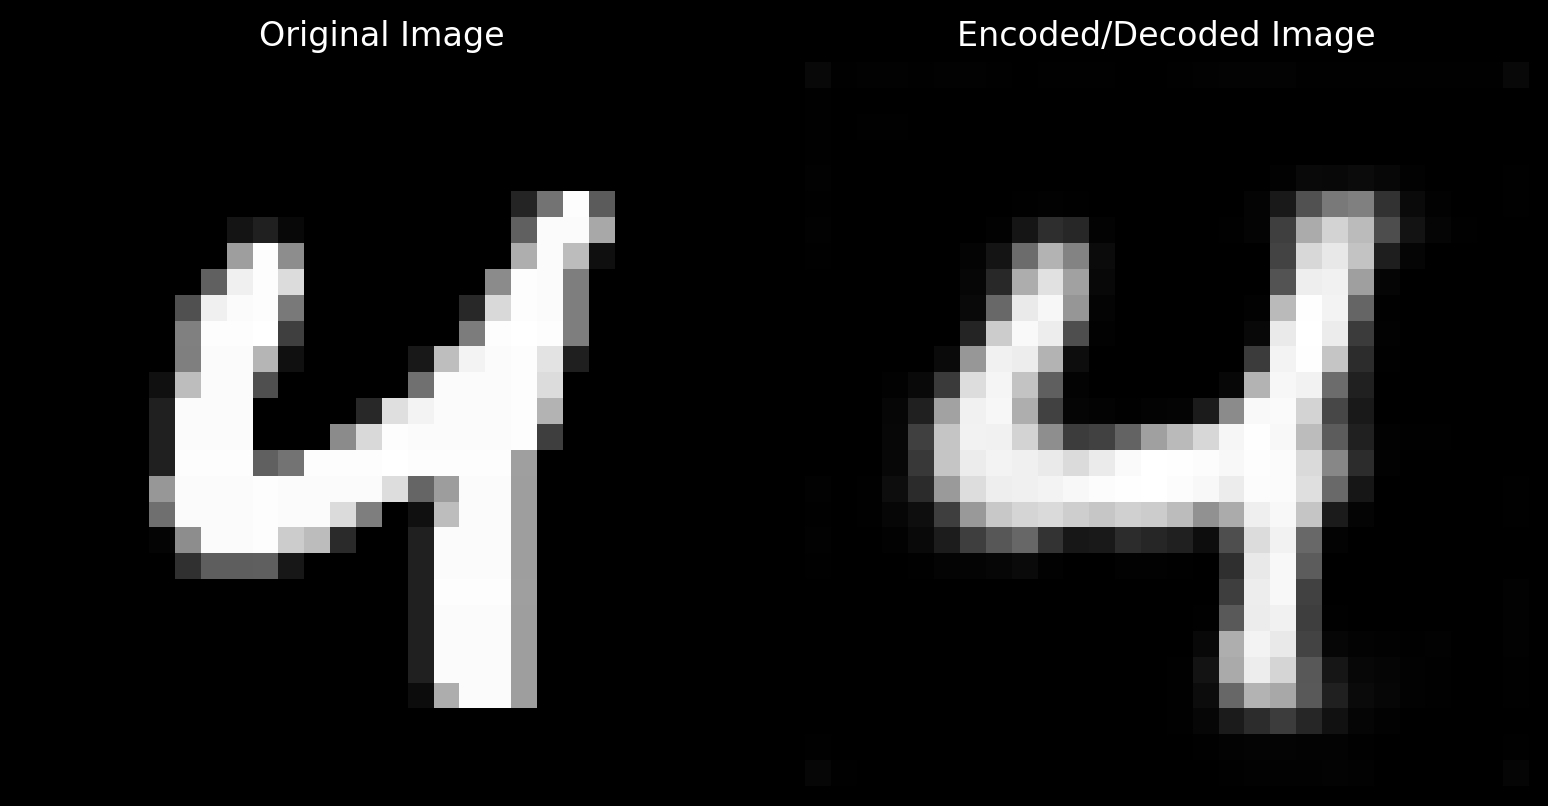

In [154]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
import numpy as np

# Создаем новую фигуру с двумя подграфиками
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 1 строка, 2 столбца

# Отображаем исходное изображение на первом подграфике
axes[0].set_title('Original Image', color='white')
axes[0].imshow(digit_sample.squeeze().cpu().numpy(), cmap='gray')
axes[0].axis('off')

# Отображаем реконструированное изображение на втором подграфике
axes[1].set_title('Encoded/Decoded Image', color='white')
axes[1].imshow(decoded_sample.squeeze().detach().cpu().numpy(), cmap='gray')
axes[1].axis('off')

# Настройка параметров фона
fig.patch.set_facecolor('black')  # Устанавливаем белый цвет фона для всей фигуры

# Отображаем фигуру
plt.tight_layout()  # Устанавливаем компактный макет
plt.show()

In [155]:
# def plot_latent(model, data, num_batches=100): # only for latent_dims = 2
#     for i, (x, y) in enumerate(data):
#         z = model.encoder(x.to(device))
#         z = z.to(device).detach().numpy()
#         plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
#         if i > num_batches:
#             plt.colorbar()
#             break

# def plot_reconstructed(model, r0=(-3, 5), r1=(-5, 3), n=12): # only for latent_dims = 2
#     w = 28
#     img = np.zeros((n*w, n*w))
#     for i, y in enumerate(np.linspace(*r1, n)): # i = [0, .., 11], y = [-10, -8.7, .., 5]
#         for j, x in enumerate(np.linspace(*r0, n)):
#             vector = np.repeat([x, y], model.message_size // 2)
#             # vector = [x, y]
#             #z = torch.Tensor([np.array(vector)]).to(device)
#             z = torch.Tensor(np.array(vector)).to(device)
#             # print(z.shape)
#             x_hat = model.decoder(z)
#             # print(x_hat.shape)
#             x_hat = x_hat.reshape(28, 28).to(device).detach().numpy()
#             # print(img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w].shape)
#             img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
#     plt.imshow(img, extent=[*r0, *r1])

# plot_reconstructed(autoencoder_1)

1048576


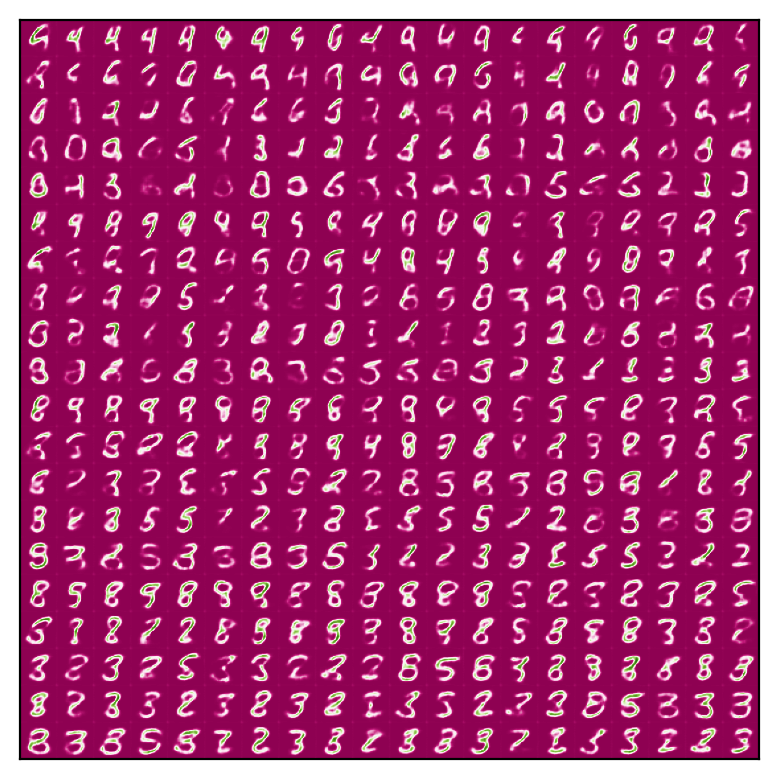

In [163]:
import itertools

# def plot_reconstructed2(model, r0=(-5, 10), r1=(-10, 5), n=4):
def plot_reconstructed2(model, r0=(-1, 2), r1=(-2, 1), n=4):
    w = 28
    imgs_in_row = 20
    img = np.zeros((imgs_in_row * w, imgs_in_row * w))
    # print(img.shape)
    latent_dim = model.message_size  # Размерность латентного пространства (то есть тот параметр с которым учили нейронку, длина вектора закодированного)
    # Создаем массив значений для первого диапазона
    values_r0 = np.linspace(*r0, n)
    # Создаем массив значений для второго диапазона
    values_r1 = np.linspace(*r1, n)

    values = [values_r0, values_r1]
    all_values = []
    for i in range(latent_dim):
        # print(values[i % len(values)])
        all_values.append(values[i % len(values)])

    all_combinations = itertools.product(*all_values)  # Все возможные комбинации значений
    total_combinations_cnt = n ** latent_dim
    print(total_combinations_cnt)
    # selected_combinations = list(itertools.islice(all_combinations, None, None, 144))
    #
    # count = 0
    # for _ in all_combinations:
    #     count += 1
    # print(count)

    # Для каждой комбинации значений создаем вектор и декодируем его
    count = 0
    for i, combination in enumerate(all_combinations):
        # if i > 144:
        #     break
        module = total_combinations_cnt / (imgs_in_row ** 2)
        rounded_up = int(module) + (module > int(module))
        if i % rounded_up != 0: # all_combinations count divide 144 (12 * 12 img)
            continue
        vector = np.array(combination)  # Создаем вектор из текущей комбинации значений
        z = torch.Tensor(vector).to(device)
        # z = torch.Tensor(combination).to(device)
        x_hat = model.decoder(z)
        x_hat = x_hat.reshape(w, w).to(device).detach().numpy()
        # if i > 144:
        #     break

        # print(count // 12 * w, (count // 12 + 1) * w, count % 12 * w, (count % 12 + 1) * w)
        # print(img[count // 12 * w : (count // 12 + 1) * w, count % 12 * w : (count % 12 + 1) * w].shape)
        # print(count)
        img[count // imgs_in_row * w : (count // imgs_in_row + 1) * w, count % imgs_in_row * w : (count % imgs_in_row + 1) * w] = x_hat
        count += 1
        # img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
        # img[(n - 1 - i // n) * w:(n - i // n) * w, (i % n) * w:((i % n) + 1) * w] = x_hat

    # print(count)
    plt.imshow(img, extent=[*r0, *r1], cmap="PiYG")
    # plt.imshow(img, extent=[*r0, *r1], cmap="PuOr")
    # plt.imshow(img, extent=[*r0, *r1], cmap="binary")
    # plt.imshow(img, extent=[*r0, *r1], cmap="gist_gray")
    # plt.imshow(img, extent=[*r0, *r1], cmap="gist_gray_r")
    # plt.imshow(img, extent=[*r0, *r1], cmap="winter")
    # plt.imshow(img, extent=[*r0, *r1], cmap="ocean_r")
    # plt.imshow(img, extent=[*r0, *r1], cmap="jet")
    # plt.imshow(img, extent=[*r0, *r1], cmap="ocean")
    # 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'
    plt.xticks([])
    plt.yticks([])

plot_reconstructed2(autoencoder_1)

In [165]:
digits = [0] * autoencoder_1.message_size  # Словарь для хранения найденных цифр
cnt = 0
while cnt < autoencoder_1.message_size:
    x, y = next(iter(data))  # Получаем следующий батч данных
    for i in range(10):
        if (i in y) and (not torch.is_tensor(digits[i])):
            digits[i] = (x[y == i][0]).unsqueeze(0).to(device)
            cnt += 1
            # print(cnt)

# digits = sorted(digits)
# for index, value in enumerate(digits):
#     print(index) # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

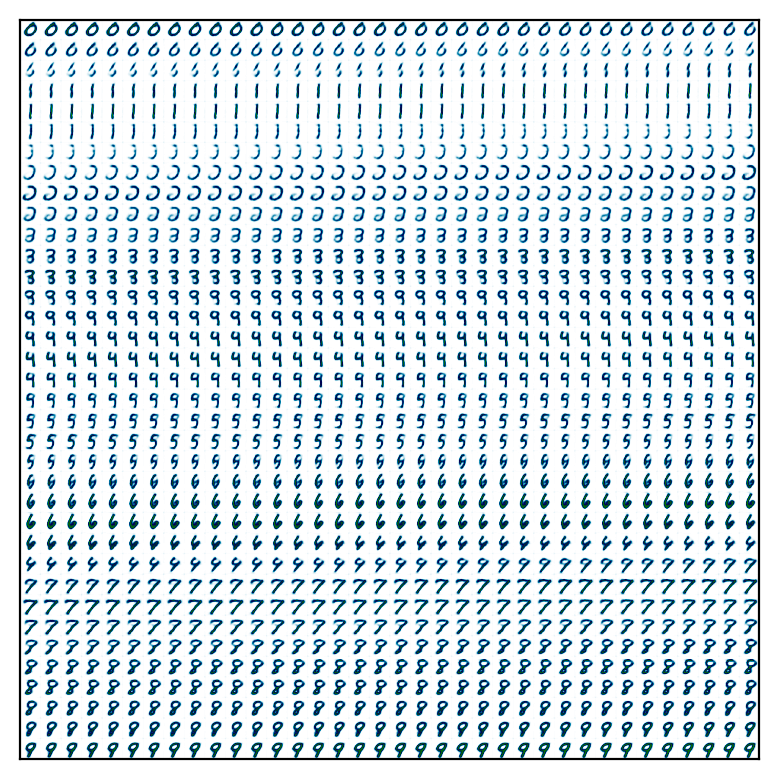

In [166]:
def interpolate(model, digits_original, n=36):
    digits_enc = [0] * model.message_size
    for index, value in enumerate(digits_original):
        digits_enc[index] = model.encoder(value)

    stacks = [0] * (model.message_size - 1)
    for i, value in enumerate(digits_enc[:-1]):
        stacks[i] = [digits_enc[i] + (digits_enc[i + 1] - digits_enc[i]) * t for t in np.linspace(-0, 1, (n ** 2) // (model.message_size - 1) )]

    sumstacks = []
    for _, value in enumerate(stacks):
        sumstacks += value
    # print(sumstacks)
    z = torch.stack(sumstacks)

    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to(device).detach().numpy()
    w = 28
    img = np.zeros((n * w, n * w))
    for i, x_hat in enumerate(interpolate_list):
        img[i // n * w : (i // n + 1) * w, i % n * w : (i % n + 1) * w] = x_hat.reshape(w, w)
    plt.imshow(img, cmap="ocean_r")
    plt.xticks([])
    plt.yticks([])

interpolate(autoencoder_1, digits)

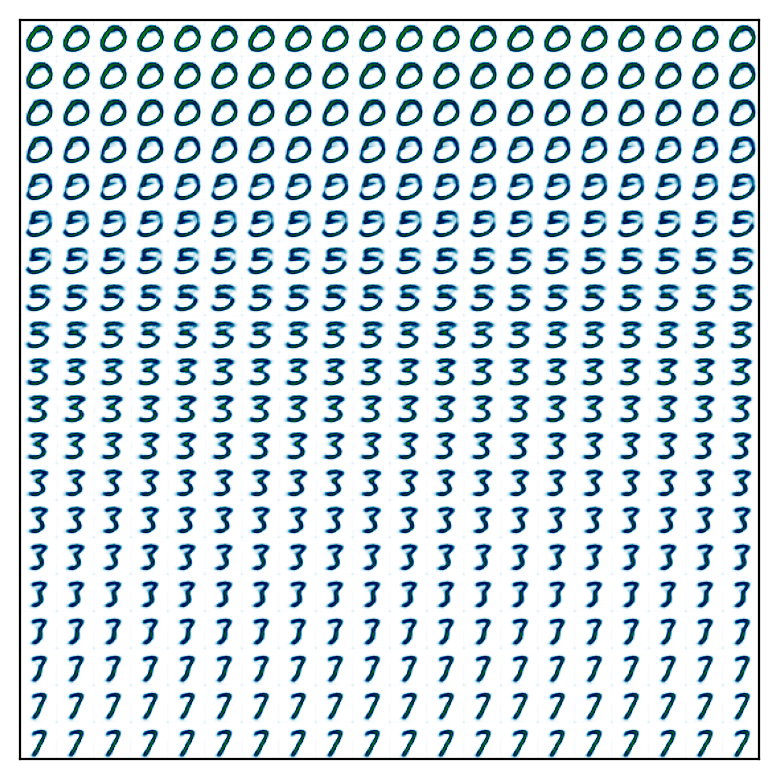

In [167]:
x_0, x_1, x_2 = None, None, None
count = 0
while x_0 is None or x_1 is None or x_2 is None:
    x, y = next(iter(data)) # hack to grab a batch
    if x_0 is None:
        tmp = x[y == 0]
        x_0 = tmp if tmp.shape[0] else None # find a 0
    if x_1 is None:
        tmp = x[y == 3]
        x_1= tmp if tmp.shape[0] else None
    if x_2 is None:
        tmp = x[y == 7]
        x_2 = tmp if tmp.shape[0] else None

    count += 1
    if 19 < count: # prevent endless loop
        break

x_0 = (x_0[0]).unsqueeze(0).to(device)
x_1 = (x_1[0]).unsqueeze(0).to(device)
x_2 = (x_2[0]).unsqueeze(0).to(device)

def interpolate(model, x_0, x_1, x_2, n=20):
    z_0 = model.encoder(x_0)
    z_1 = model.encoder(x_1)
    z_2 = model.encoder(x_2)
    stack1 = [z_0 + (z_1 - z_0) * t for t in np.linspace(0, 1, (n ** 2) // 2 )]
    stack2 = [z_1 + (z_2 - z_1) * t for t in np.linspace(0, 1, (n ** 2) // 2 )]
    z = torch.stack(stack1 + stack2)
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to(device).detach().numpy()
    w = 28
    img = np.zeros((n * w, n * w))
    for i, x_hat in enumerate(interpolate_list):
        img[i // n * w : (i // n + 1) * w, i % n * w : (i % n + 1) * w] = x_hat.reshape(28, 28)
    plt.imshow(img, cmap="ocean_r")
    plt.xticks([])
    plt.yticks([])

interpolate(autoencoder_1, x_0, x_1, x_2)